![forecasting_framework](../forecasting_framework.png)

In [64]:
import pandas as pd
import matplotlib.pyplot as plt

from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf, plot_predict
from math import sqrt

In [5]:
TRAIN_CSV_PATH = r"../datasets/train.csv"
PRICES_CSV_PATH = r"../datasets/prices.csv"
CAL_CSV_PATH = r"../datasets/calendar.csv"

In [6]:
df_train = pd.read_csv(TRAIN_CSV_PATH)
df_train.head()

,id,item_id,subcat_id,category_id,store_id,region_id,d_1,d_2,d_3,d_4,...,d_1910,d_1911,d_1912,d_1913,d_1914,d_1915,d_1916,d_1917,d_1918,d_1919
0,Beauty_1_001_East_1,Beauty_1_001,Beauty_1,Beauty,East_1,East,0,0,0,0,...,3,0,1,1,0,0,0,2,0,3
1,Beauty_1_002_East_1,Beauty_1_002,Beauty_1,Beauty,East_1,East,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
2,Beauty_1_003_East_1,Beauty_1_003,Beauty_1,Beauty,East_1,East,0,0,0,0,...,0,1,1,1,0,0,1,1,0,2
3,Beauty_1_004_East_1,Beauty_1_004,Beauty_1,Beauty,East_1,East,0,0,0,0,...,1,3,7,2,0,0,1,2,4,1
4,Beauty_1_005_East_1,Beauty_1_005,Beauty_1,Beauty,East_1,East,0,0,0,0,...,2,2,2,4,1,0,2,3,1,0


In [7]:
# Convert to appropriate datatypes
df_train["id"] = df_train["id"].astype("string")
df_train["item_id"] = df_train["item_id"].astype("string")
df_train["subcat_id"] = df_train["subcat_id"].astype("string")
df_train["category_id"] = df_train["category_id"].astype("string")
df_train["store_id"] = df_train["store_id"].astype("string")
df_train["region_id"] = df_train["region_id"].astype("string")

In [8]:
df_cal = pd.read_csv(CAL_CSV_PATH)
df_cal.head()

,date,wm_yr_wk,weekday,wday,month,year,d
0,2011-01-29,11101,Saturday,1,1,2011,d_1
1,2011-01-30,11101,Sunday,2,1,2011,d_2
2,2011-01-31,11101,Monday,3,1,2011,d_3
3,2011-02-01,11101,Tuesday,4,2,2011,d_4
4,2011-02-02,11101,Wednesday,5,2,2011,d_5


In [9]:
# Change dtypes
df_cal["date"] = pd.to_datetime(df_cal["date"])
df_cal["weekday"] = df_cal["weekday"].astype("string")
df_cal["d"] = df_cal["d"].astype("string")
df_cal["wm_yr_wk"] = df_cal["wm_yr_wk"].astype(int)

# Add column with months in string
month_names_ls = ["Jan", "Feb", "Mar", "Apr", "May", "Jun", "Jul", "Aug", "Sep", "Oct", "Nov", "Dec"]
month_int_ls = list(range(1, 13))
month_names_dict = {month_int_ls[i]: month_names_ls[i] for i in range(len(month_int_ls))}

df_cal["month_name"] = df_cal["month"].replace(month_names_dict)

In [10]:
# Save day IDs from train
day_ids = list(df_train.columns[6:])

df_items_temp = df_train[["id"]+day_ids].T
df_items_temp.columns = df_items_temp.iloc[0, :]

# Drop first row
df_items_temp = df_items_temp.iloc[1: , :]

# Copy the index to merge date
df_items_temp["d"] = df_items_temp.index

# Merge date into df
df_items_temp = pd.merge(df_items_temp, df_cal, on = "d", how = "left")
df_items_temp = df_items_temp.set_index("date")

# Calculate average items across items per day
df_items_temp["avg_items_sold"] = df_items_temp[list(df_train["id"])].mean(axis = 1)

In [11]:
df_items_temp.head()

,Beauty_1_001_East_1,Beauty_1_002_East_1,Beauty_1_003_East_1,Beauty_1_004_East_1,Beauty_1_005_East_1,Beauty_1_006_East_1,Beauty_1_007_East_1,Beauty_1_008_East_1,Beauty_1_009_East_1,Beauty_1_010_East_1,...,Food_3_826_West_3,Food_3_827_West_3,d,wm_yr_wk,weekday,wday,month,year,month_name,avg_items_sold
date,,,,,,,,,,,,,,,,,,,,,
2011-01-29,0,0,0,0,0,0,0,12,2,0,...,0,0,d_1,11101,Saturday,1,1,2011,Jan,1.070220
2011-01-30,0,0,0,0,0,0,0,15,0,0,...,0,0,d_2,11101,Sunday,2,1,2011,Jan,1.041292
2011-01-31,0,0,0,0,0,0,0,0,7,1,...,0,0,d_3,11101,Monday,3,1,2011,Jan,0.780026
2011-02-01,0,0,0,0,0,0,0,0,3,0,...,0,0,d_4,11101,Tuesday,4,2,2011,Feb,0.833454
2011-02-02,0,0,0,0,0,0,0,0,0,0,...,0,0,d_5,11101,Wednesday,5,2,2011,Feb,0.627944


#### Plot differencing for lag 1 - 7

In [50]:
def plot_differencing(series, n = 8) :

    fig, axes = plt.subplots(n, 3, figsize = (20,25))

    axes[0, 0].plot(series); axes[0, 0].set_title('Original Series')
    plot_acf(series, ax=axes[0, 1])

    for i in range(1, n) :
        diff_series = series.diff(periods = i)

        axes[i, 0].plot(diff_series); axes[i, 0].set_title(f'{i}th Order Differencing')
        plot_acf(diff_series.dropna(), ax=axes[i, 1])
        plot_pacf(diff_series.dropna(), method='ywm', ax = axes[i, 2])


    plt.show()

c:\Users\Tristan\Desktop\Assignments\ADS\ads-final-project\ads_env\lib\site-packages\statsmodels\graphics\tsaplots.py:353: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  FutureWarning,


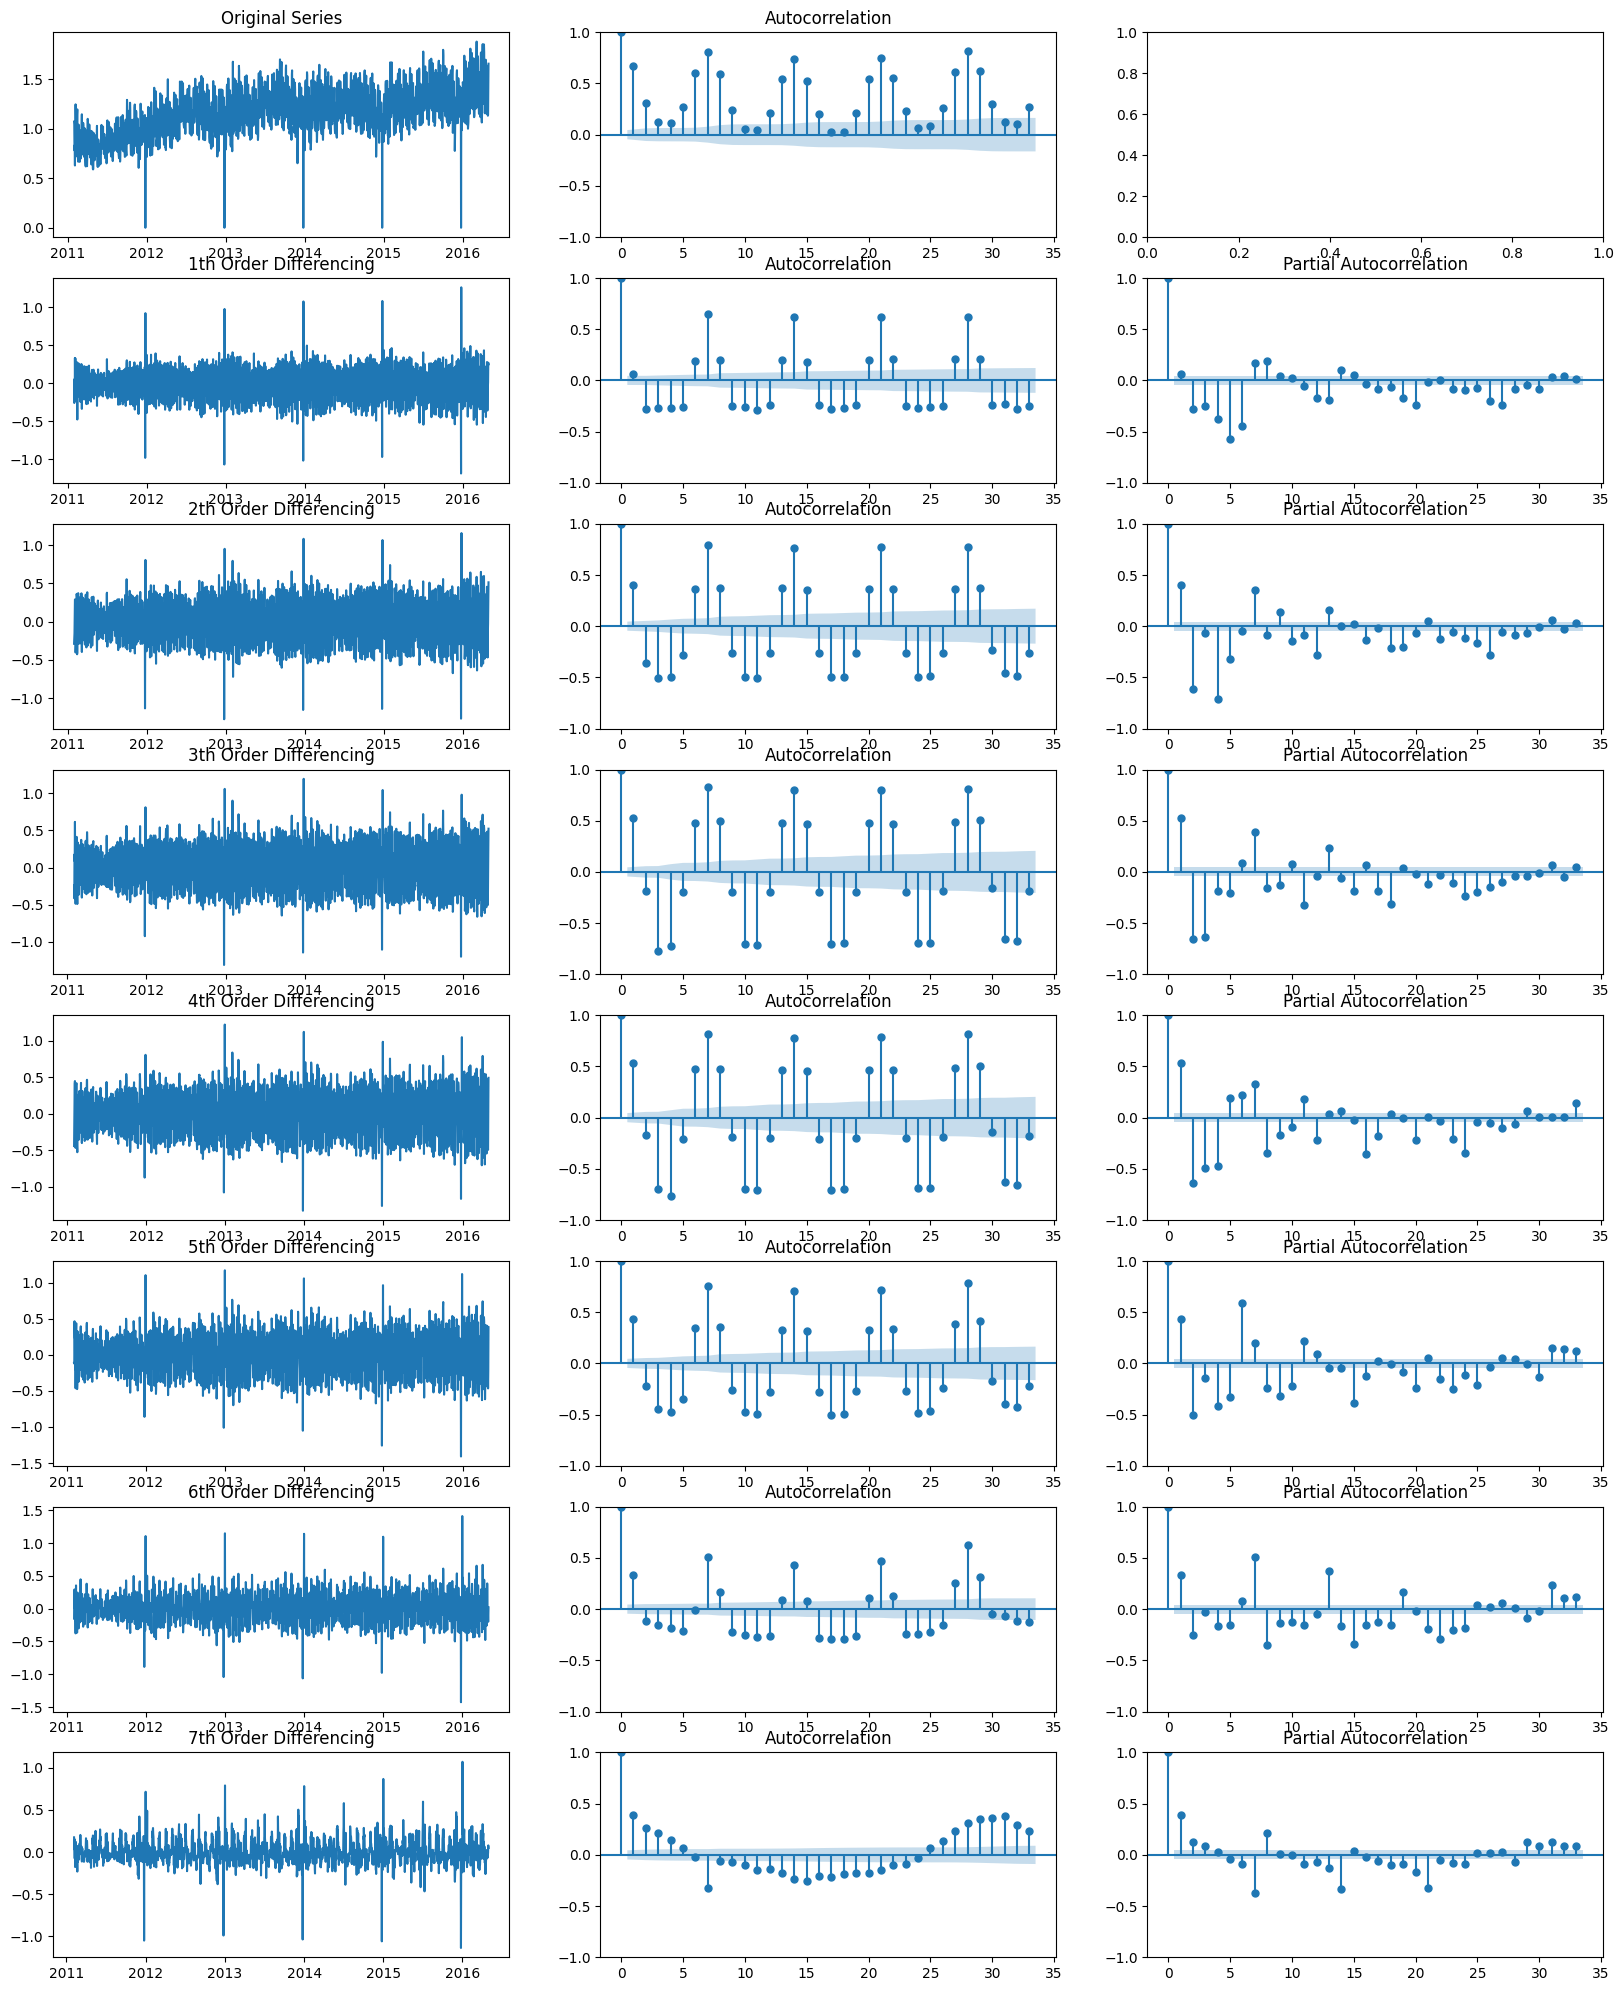

In [51]:
plot_differencing(df_items_temp["avg_items_sold"])

### Testing ARIMA model on average items sold

Copying the code from [here](https://machinelearningmastery.com/arima-for-time-series-forecasting-with-python/)
 and [here](https://www.machinelearningplus.com/time-series/arima-model-time-series-forecasting-python/)

In [69]:
x = df_items_temp["avg_items_sold"]

model = ARIMA(x, order = (4, 7, 5))
fitted = model.fit()

c:\Users\Tristan\Desktop\Assignments\ADS\ads-final-project\ads_env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\Users\Tristan\Desktop\Assignments\ADS\ads-final-project\ads_env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\Users\Tristan\Desktop\Assignments\ADS\ads-final-project\ads_env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\Users\Tristan\Desktop\Assignments\ADS\ads-final-project\ads_env\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA pa

In [70]:
print(fitted.summary())

                               SARIMAX Results                                
Dep. Variable:         avg_items_sold   No. Observations:                 1919
Model:                 ARIMA(4, 7, 5)   Log Likelihood               -1089.715
Date:                Thu, 20 Apr 2023   AIC                           2199.430
Time:                        00:08:20   BIC                           2254.989
Sample:                    01-29-2011   HQIC                          2219.876
                         - 04-30-2016                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -1.6673      0.017    -95.384      0.000      -1.702      -1.633
ar.L2         -2.1655      0.023    -95.546      0.000      -2.210      -2.121
ar.L3         -1.4615      0.023    -62.365      0.0

Residuals plot

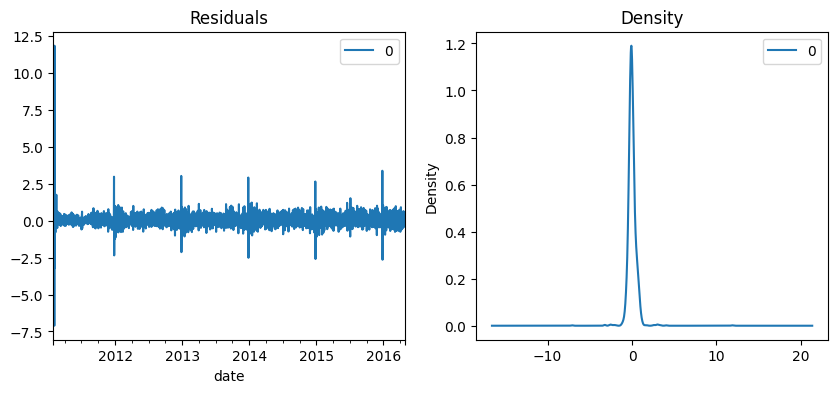

In [71]:
residuals = pd.DataFrame(fitted.resid)
fig, ax = plt.subplots(1,2, figsize = (10, 4))
residuals.plot(title="Residuals", ax=ax[0])
residuals.plot(kind='kde', title='Density', ax=ax[1])
plt.show()

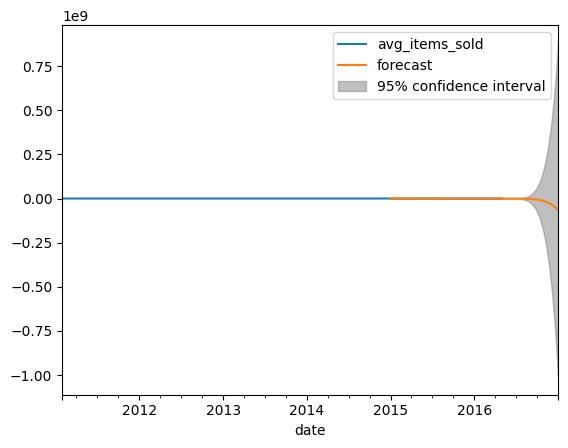

In [73]:
# Actual vs Fitted
fig, ax = plt.subplots()
ax = df_items_temp["avg_items_sold"].plot(ax=ax)
plot_predict(fitted, "2015-01-01", "2016-12-31", ax = ax)
plt.show()

### Forecasting with ARIMA

In [56]:
# Set number of days to forecast into the future
n = 7

# Split into test and train
size = int(len(x) * 0.8)
x_train, x_test = x[0:size], x[size:size+n]

# Build Model
model = ARIMA(x_train, order=(4, 7, 5))  
fitted = model.fit()

# Forecast n days ahead
fc = fitted.forecast(n) 

# Make as pandas series
fc_series = pd.Series(fc, index=df_items_temp["avg_items_sold"][size:size+n].index)

c:\Users\Tristan\Desktop\Assignments\ADS\ads-final-project\ads_env\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
c:\Users\Tristan\Desktop\Assignments\ADS\ads-final-project\ads_env\lib\site-packages\statsmodels\base\model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


In [57]:
print(fitted.summary())

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 1535
Model:                 ARIMA(4, 7, 5)   Log Likelihood                -729.436
Date:                Wed, 19 Apr 2023   AIC                           1478.873
Time:                        23:56:20   BIC                           1532.190
Sample:                             0   HQIC                          1498.717
                               - 1535                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -1.5929      0.017    -95.110      0.000      -1.626      -1.560
ar.L2         -2.0171      0.025    -82.019      0.000      -2.065      -1.969
ar.L3         -1.3723      0.023    -59.540      0.0

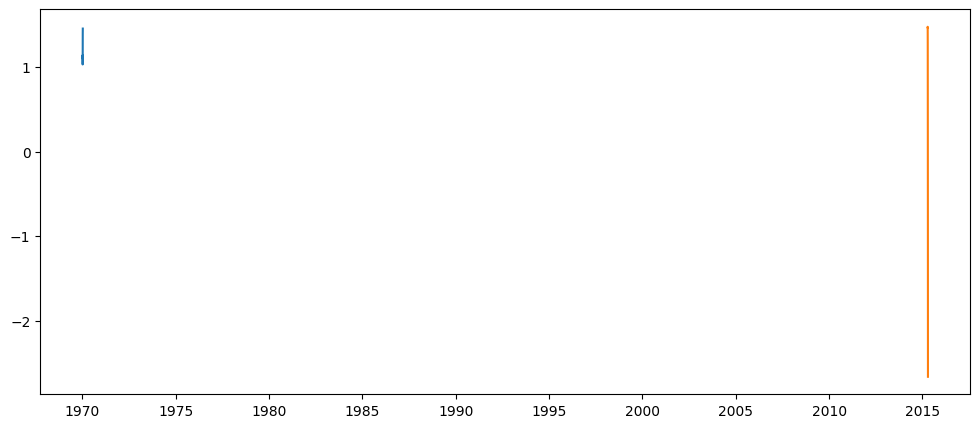

In [58]:
plt.figure(figsize=(12,5), dpi=100)
# plt.plot(x_train, label='training')
plt.plot(x_test, label='actual')
plt.plot(fc_series, label='forecast')
plt.show()

#### Rolling forecast ARIMA model

In [19]:
history = [x for x in x_train]
predictions = list()

for t in range(len(x_test)):
    
    # Order taken from eda (hypothesis after looking at plots) 
    print(t)
    model = ARIMA(history, order=(11,7,8))
    model_fit = model.fit()
    output = model_fit.forecast()
    yhat = output[0]
    predictions.append(yhat)
    obs = x_test[t]
    history.append(obs)
    # print('predicted=%f, expected=%f' % (yhat, obs))

c:\Users\Tristan\Desktop\Assignments\ADS\ads-final-project\ads_env\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
c:\Users\Tristan\Desktop\Assignments\ADS\ads-final-project\ads_env\lib\site-packages\statsmodels\base\model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


predicted=1.473821, expected=1.131322


c:\Users\Tristan\Desktop\Assignments\ADS\ads-final-project\ads_env\lib\site-packages\statsmodels\base\model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


predicted=1.202362, expected=1.101902


c:\Users\Tristan\Desktop\Assignments\ADS\ads-final-project\ads_env\lib\site-packages\statsmodels\base\model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


predicted=1.060877, expected=1.137750


c:\Users\Tristan\Desktop\Assignments\ADS\ads-final-project\ads_env\lib\site-packages\statsmodels\base\model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


predicted=1.093107, expected=1.030863


In [ ]:
rmse = sqrt(mean_squared_error(x_test, predictions))
print('Test RMSE: %.3f' % rmse)

In [ ]:
plt.plot(x_test)
plt.plot(predictions, color='red')
plt.show()